In [1]:
import pandas as pd
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
%matplotlib inline

** This is the iris dataset classification example.The dataset is downloaded from https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data. Each sample has 4 features (sepal length, sepal width, petal length, petal width) and is classified into one of the 3 classes (iris-setosa, iris-versicolor,iris-virginica). Decision tree, random forest and logistic regression modules from the spark.ml library are used for classification. **

In [2]:
import ibmos2spark

# @hidden_cell
credentials = {
    'auth_url': 'https://identity.open.softlayer.com',
    'project_id': '5255011bbec640b5b65887c30a697775',
    'region': 'dallas',
    'user_id': 'd5a715617ba24fb28fa27e6c37016cd5',
    'username': 'member_961fb9fb8cbcdb9c05c7f761d07710754f04e371',
    'password': 'I*7eN0xng.ZgZvsK'
}

configuration_name = 'os_2324dd88d6d2434d8e40abae94b1b978_configs'
bmos = ibmos2spark.bluemix(sc, credentials, configuration_name)

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
df_iris = spark.read\
  .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
  .option('header', 'false')\
  .option('inferSchema','true')\
  .load(bmos.url('DefaultProjecthongsang1976gmailcom', 'iris.data'))
df_iris.take(5)

[Row(_c0=5.1, _c1=3.5, _c2=1.4, _c3=0.2, _c4='Iris-setosa'),
 Row(_c0=4.9, _c1=3.0, _c2=1.4, _c3=0.2, _c4='Iris-setosa'),
 Row(_c0=4.7, _c1=3.2, _c2=1.3, _c3=0.2, _c4='Iris-setosa'),
 Row(_c0=4.6, _c1=3.1, _c2=1.5, _c3=0.2, _c4='Iris-setosa'),
 Row(_c0=5.0, _c1=3.6, _c2=1.4, _c3=0.2, _c4='Iris-setosa')]

** Assign proper column names to the dataframe **

In [3]:
df_iris = df_iris.withColumnRenamed('_c0', 'sepal_length')\
                 .withColumnRenamed('_c1', 'sepal_width')\
                 .withColumnRenamed('_c2', 'petal_length')\
                 .withColumnRenamed('_c3', 'petal_width')\
                 .withColumnRenamed('_c4', 'iris_class')
df_iris.printSchema()
df_iris.show(5)

root
 |-- sepal_length: double (nullable = true)
 |-- sepal_width: double (nullable = true)
 |-- petal_length: double (nullable = true)
 |-- petal_width: double (nullable = true)
 |-- iris_class: string (nullable = true)

+------------+-----------+------------+-----------+-----------+
|sepal_length|sepal_width|petal_length|petal_width| iris_class|
+------------+-----------+------------+-----------+-----------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|
+------------+-----------+------------+-----------+-----------+
only showing top 5 rows



** Convert iris-class strings into numbers **

In [4]:
from pyspark.ml.feature import StringIndexer

In [5]:
indexer = StringIndexer(inputCol='iris_class',outputCol='label')
df = indexer.fit(df_iris).transform(df_iris)
df.show(5)

+------------+-----------+------------+-----------+-----------+-----+
|sepal_length|sepal_width|petal_length|petal_width| iris_class|label|
+------------+-----------+------------+-----------+-----------+-----+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|  0.0|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|  0.0|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|  0.0|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|  0.0|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|  0.0|
+------------+-----------+------------+-----------+-----------+-----+
only showing top 5 rows



In [6]:
from pyspark.ml.feature import VectorAssembler

In [7]:
assembler = VectorAssembler(inputCols=['sepal_length','sepal_length','petal_length','petal_width'],
                           outputCol='features')
df_assembled = assembler.transform(df)
df_assembled.show(5)

+------------+-----------+------------+-----------+-----------+-----+-----------------+
|sepal_length|sepal_width|petal_length|petal_width| iris_class|label|         features|
+------------+-----------+------------+-----------+-----------+-----+-----------------+
|         5.1|        3.5|         1.4|        0.2|Iris-setosa|  0.0|[5.1,5.1,1.4,0.2]|
|         4.9|        3.0|         1.4|        0.2|Iris-setosa|  0.0|[4.9,4.9,1.4,0.2]|
|         4.7|        3.2|         1.3|        0.2|Iris-setosa|  0.0|[4.7,4.7,1.3,0.2]|
|         4.6|        3.1|         1.5|        0.2|Iris-setosa|  0.0|[4.6,4.6,1.5,0.2]|
|         5.0|        3.6|         1.4|        0.2|Iris-setosa|  0.0|[5.0,5.0,1.4,0.2]|
+------------+-----------+------------+-----------+-----------+-----+-----------------+
only showing top 5 rows



In [8]:
df_final = df_assembled.select('features','label')
df_final.show(5)

+-----------------+-----+
|         features|label|
+-----------------+-----+
|[5.1,5.1,1.4,0.2]|  0.0|
|[4.9,4.9,1.4,0.2]|  0.0|
|[4.7,4.7,1.3,0.2]|  0.0|
|[4.6,4.6,1.5,0.2]|  0.0|
|[5.0,5.0,1.4,0.2]|  0.0|
+-----------------+-----+
only showing top 5 rows



** Split data into training set and test set at the ratio of 0.7:0.3 **

In [9]:
#train_data,test_data = df_final.randomSplit([0.7,0.3], seed=1)
train_data,test_data = df_assembled.randomSplit([0.7,0.3], seed=1)
print('Size of training set: ' + str(train_data.count()))
print('Size of test set: ' + str(test_data.count()))

Size of training set: 106
Size of test set: 44


In [10]:
from pyspark.ml.classification import (RandomForestClassifier,
                                       DecisionTreeClassifier,LogisticRegression)

In [11]:
dtc = DecisionTreeClassifier(labelCol='label',featuresCol='features')
rfc = RandomForestClassifier(labelCol='label',featuresCol='features')
lgr = LogisticRegression(labelCol='label',featuresCol='features')

In [12]:
dtc_model = dtc.fit(train_data)
rfc_model = rfc.fit(train_data)
lgr_model = lgr.fit(train_data)

In [13]:
dtc_predictions = dtc_model.transform(test_data)
rfc_predictions = rfc_model.transform(test_data)
lgr_predictions = lgr_model.transform(test_data)

In [14]:
dtc_predictions.show(5)
rfc_predictions.show(5)
lgr_predictions.show(5)

+------------+-----------+------------+-----------+---------------+-----+-----------------+--------------+-------------+----------+
|sepal_length|sepal_width|petal_length|petal_width|     iris_class|label|         features| rawPrediction|  probability|prediction|
+------------+-----------+------------+-----------+---------------+-----+-----------------+--------------+-------------+----------+
|         4.5|        2.3|         1.3|        0.3|    Iris-setosa|  0.0|[4.5,4.5,1.3,0.3]|[37.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|         4.7|        3.2|         1.6|        0.2|    Iris-setosa|  0.0|[4.7,4.7,1.6,0.2]|[37.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|         4.9|        2.4|         3.3|        1.0|Iris-versicolor|  1.0|[4.9,4.9,3.3,1.0]|[0.0,35.0,0.0]|[0.0,1.0,0.0]|       1.0|
|         4.9|        3.0|         1.4|        0.2|    Iris-setosa|  0.0|[4.9,4.9,1.4,0.2]|[37.0,0.0,0.0]|[1.0,0.0,0.0]|       0.0|
|         4.9|        3.1|         1.5|        0.1|    Iris-setosa|  0.0|[4.

In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [16]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", 
                                                  metricName="accuracy")

In [17]:
dtc_acc = acc_evaluator.evaluate(dtc_predictions)
rfc_acc = acc_evaluator.evaluate(rfc_predictions)
lgr_acc = acc_evaluator.evaluate(lgr_predictions)

In [18]:
print("Here are the results!")
print('-'*80)
print('A single decision tree had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('-'*80)
print('A random forest ensemble had an accuracy of: {0:2.2f}%'.format(rfc_acc*100))
print('-'*80)
print('The logistic regression classifier had an accuracy of: {0:2.2f}%'.format(lgr_acc*100))
print('-'*80)

Here are the results!
--------------------------------------------------------------------------------
A single decision tree had an accuracy of: 86.36%
--------------------------------------------------------------------------------
A random forest ensemble had an accuracy of: 93.18%
--------------------------------------------------------------------------------
The logistic regression classifier had an accuracy of: 97.73%
--------------------------------------------------------------------------------


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a60d77160>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6a603196a0>]], dtype=object)

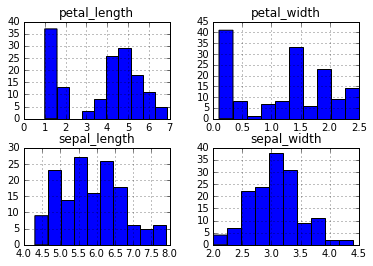

In [19]:
df_iris.toPandas().hist()

In [20]:
# Function to plot decision regions
def plot_decision_regions(x1,x2,y):
    x1_min, x1_max = x1.min() - 1, x1.max() + 1
    x2_min, x2_max = x2.min() - 1, x2.max() + 1
    x1mesh, x2mesh = np.meshgrid(np.arange(x1_min, x1_max, 0.005),
                                 np.arange(x2_min, x2_max, 0.005))            
    ymesh = scipy.interpolate.griddata((x1,x2),y,(x1mesh,x2mesh),method='nearest')
    plt.contourf(x1mesh,x2mesh,ymesh)
    plt.xlim([x1mesh.min(),x1mesh.max()])
    plt.ylim([x2mesh.min(),x2mesh.max()])

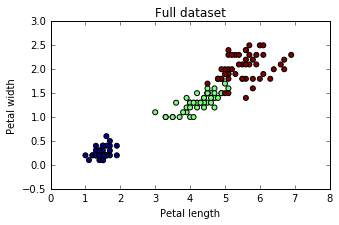

In [41]:
plt.figure(figsize=(5,3))   
plt.scatter(df.toPandas()['petal_length'],df.toPandas()['petal_width'],
            c=df.toPandas()['label'],edgecolor='black',s=25)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.title('Full dataset')
plt.show()

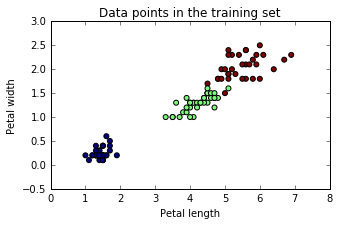

In [49]:
plt.figure(figsize=(5,3))   
plt.scatter(train_data.toPandas()['petal_length'],train_data.toPandas()['petal_width'],
            c=train_data.toPandas()['label'],edgecolor='black',s=25)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.title('Data points in the training set')
plt.show()

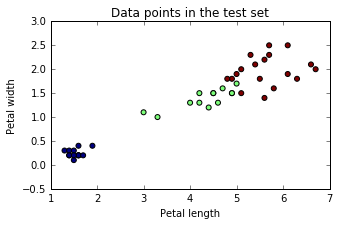

In [48]:
plt.figure(figsize=(5,3))   
plt.scatter(test_data.toPandas()['petal_length'],test_data.toPandas()['petal_width'],
            c=test_data.toPandas()['label'],edgecolor='black',s=25)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.title('Data points in the test set')
plt.show()

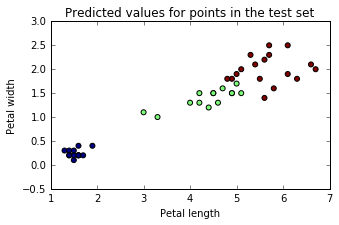

In [51]:
plt.figure(figsize=(5,3))   
plt.scatter(lgr_predictions.toPandas()['petal_length'],lgr_predictions.toPandas()['petal_width'],
            c=lgr_predictions.toPandas()['prediction'],edgecolor='black',s=25)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
plt.title('Predicted values for points in the test set')
plt.show()